# 3. SHO Fitting in Pytorch


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from m3util.viz.printing import printer
from m3util.viz.style import set_style
from m3util.ml.rand import set_seeds
from m3util.util.IO import download_and_unzip
from belearn.dataset.dataset import BE_Dataset
from belearn.viz.viz import Viz
from belearn.functions.sho import SHO_nn
from belearn.dataset.analytics import print_mse
from autophyslearn.postprocessing.complex import ComplexPostProcessor
from autophyslearn.spectroscopic.nn import Multiscale1DFitter, Model


printing = printer(basepath = './Figures/')


set_style("printing")
set_seeds(seed=42)

%matplotlib inline

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42


2024-09-13 11:31:28.475203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 11:31:28.490730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 11:31:28.495528: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 11:31:28.507801: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 11:31:29.071754: W tensorflow/compiler/tf2

tensorflow seed was set to 42


## Loads Data


In [6]:
# Specify the filename and the path to save the file
filename = 'data_raw.h5'
save_path = "./Data"

data_path = save_path + "/" + filename

In [7]:
# instantiate the dataset object
dataset = BE_Dataset(data_path, SHO_fit_func_LSQF=SHO_nn)

# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
├ Noisy_Data_1_SHO_Fit
  --------

## Testing the Torch Function

The function for a simple-harmonic oscillator needs to be recast in PyTorch. Here we prove that the PyTorch function is implemented identically to the Numpy model.

Note: This uses the results from the least squares fitting LSQF results.


In [8]:
# insatiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]

BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 0), (-np.pi, np.pi)],
             image_scalebar=image_scalebar)

{'resampled': False, 'label': 'Raw', 'noise': 0, 'measurement_state': 'all'}
True 

predicted 

./Figures/Figure_3_1_PyTorch_fit_tester.png
./Figures/Figure_3_1_PyTorch_fit_tester.svg


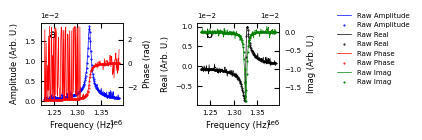

In [9]:
true = {"resampled": False,
        "label": "Raw",
        "noise": 0, 
        "measurement_state": "all"}

predicted = {"fitter": "LSQF", "resampled": False, "label": "Raw", "scaled": False, "noise" : 0}

BE_viz.fit_tester(true, predicted, filename="Figure_3_1_PyTorch_fit_tester")

**Figure 3.1** Shows the result of the PyTorch function. The result based on the LSQF results shows that the PyTorch function is implemented correctly.


## Pytorch Model

### Model Architecture


### Scaling the Data

When training the neural network it is useful to scale the data. We apply a global scaler such that the spectrum have a mean of 0 and a standard deviation of 1.

#### Visualizing the Scaled Data


./Figures/Figure_8_Scaled Raw Data.png
./Figures/Figure_8_Scaled Raw Data.svg


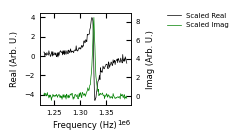

In [10]:
state = {"fitter": "LSQF", "resampled": True, "scaled": True, "label": "Scaled"}

BE_viz.nn_checker(state, filename="Figure_8_Scaled Raw Data")

**Figure 3.2** shows the scaled data. The data is scaled to have a mean of 0 and a standard deviation of 1. This is done using a global scaler of the entire spectrum.


current_SHO_ranges: [(0, 0.00015), (1310000.0, 1330000.0), (-300, 0), (-3.141592653589793, 3.141592653589793)]
current_dataset_state: {'raw_format': 'complex', 'fitter': 'LSQF', 'scaled': False, 'output_shape': 'pixels', 'measurement_state': 'all', 'LSQF_phase_shift': 1.5707963267948966, 'NN_phase_shift': None, 'noise': 0, 'loop_interpolated': False}
./Figures/Figure_9_Phase_Shifted_Scaled_Histograms.png
./Figures/Figure_9_Phase_Shifted_Scaled_Histograms.svg


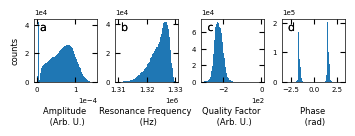

In [11]:
dataset.LSQF_phase_shift = np.pi / 2

BE_viz.SHO_hist(
    dataset.SHO_fit_results(), filename="Figure_9_Phase_Shifted_Scaled_Histograms"
)

**Figure 3.3** shows the histograms of the scaled a) amplitude, b) resonance frequency, c) quality factor, and d) phase. These are approximated from the LSQF. These are the scaled values that are predicted by the neural network. Note there is a transformation applied to the phase.


### Training the Model

We will train the model from scratch. Generally the model trains very well in a few epochs. This will take less than 5 minutes to train on a GPU.


In [12]:
set_seeds(seed=42)

postprocessor = ComplexPostProcessor(dataset)

model_ = Multiscale1DFitter(SHO_nn, # function 
                            dataset.frequency_bin, # x data
                            2, # input channels
                            4, # output channels
                            dataset.SHO_scaler, 
                            postprocessor)

# instantiate the model
model = Model(model_, dataset, training=True, model_basename="SHO_Fitter_original_data")

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
Using GPU NVIDIA GeForce RTX 3090


In [13]:
# constructs a test train split
X_train, X_test, y_train, y_test = dataset.test_train_split_(shuffle=True)

In [14]:
train = True

if train:
    # fits the model
    model.fit(
        dataset.X_train,
        500,
        optimizer="Adam",
        epochs = 5,
    )
else:
    model.load(
        "/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/SHO_Fitter_original_data_model_epoch_5_train_loss_0.0449272525189978.pth"
    )

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


/home/ferroelectric/anaconda3/envs/m3/lib/python3.11/site-packages/torch/autograd/graph.py:769: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1203.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Adam
epoch : 1/5, recon loss = 0.06530077
--- 17.905476331710815 seconds ---
Epoch 1, Learning Rate: 0.001
Adam
epoch : 2/5, recon loss = 0.03469515
--- 17.131024837493896 seconds ---
Epoch 2, Learning Rate: 0.001


Adam
epoch : 3/5, recon loss = 0.03433744
--- 16.83598256111145 seconds ---
Epoch 3, Learning Rate: 0.001
Adam
epoch : 4/5, recon loss = 0.03413521
--- 16.963079929351807 seconds ---
Epoch 4, Learning Rate: 0.001
Adam
epoch : 5/5, recon loss = 0.03404639
--- 17.171135425567627 seconds ---
Epoch 5, Learning Rate: 0.001


### Evaluate the Neural Network Results

It is always recommended to validate that the autoencoder is working correctly. We can do this by comparing the different stages of the autoencoder including the raw data, the generated curves.


./Figures/Figure_10_NN_validation_Train.png
./Figures/Figure_10_NN_validation_Train.svg


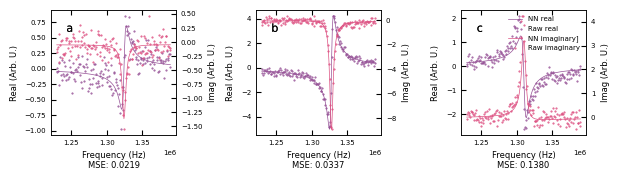

In [15]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_train,
    prediction=model,
    out_state={"scaled": True, "raw_format": "complex"},
    returns=True,
    filename="Figure_10_NN_validation_Train",
)

**Figure 3.4** Raw data and reconstruction of the autoendcoder for the training data. Shows the a) best, b) median, and c) worst reconstruction of the training data.


./Figures/Figure_11_NN_validation_test.png
./Figures/Figure_11_NN_validation_test.svg


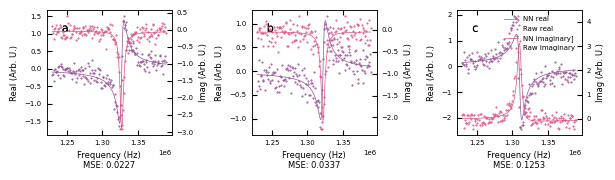

In [16]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_test,
    prediction=model,
    out_state={"scaled": True, "measurement State": "complex"},
    returns=True,
    filename="Figure_11_NN_validation_test",
)

**Figure 3.5** Raw data and reconstruction of the autoendcoder for the test data. Shows the a) best, b) median, and c) worst reconstruction of the test data.


./Figures/Figure_12_NN_validation_full_data.png
./Figures/Figure_12_NN_validation_full_data.svg


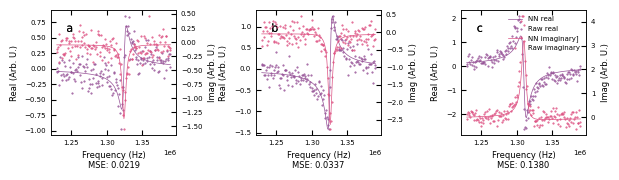

In [17]:
state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": False,
    "scaled": True,
    "output_shape": "index",
}

X_data, Y_data = dataset.NN_data()

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    state,
    prediction=model,
    out_state={"scaled": True, "measurement State": "complex"},
    returns=True,
    filename="Figure_12_NN_validation_full_data",
)

**Figure 3.6** Raw data and reconstruction of the autoendcoder for the entire data. Shows the a) best, b) median, and c) worst reconstruction of the entire data.


### Calculate the MSE error

We can calculate the MSE error for the training, test, and entire data set.


In [18]:
X_data, Y_data = dataset.NN_data()
LSQF_ = {'resampled': True,
                'raw_format': 'complex',
                'fitter': 'LSQF',
                'scaled': True,
                'output_shape': 'index',
                'measurement_state': 'all',
                'resampled_bins': 165,
                'LSQF_phase_shift': 1.5707963267948966,
                'NN_phase_shift': None,
                'noise': 0}

data = (LSQF_, X_data, X_test, X_train)
labels = ["LSQF", "Full Data", "Test Data", "Train Data"]

print_mse(model_, model, data, labels)

LSQF Mean Squared Error: 0.0344539
Full Data Mean Squared Error: 0.0338742
Test Data Mean Squared Error: 0.0338655
Train Data Mean Squared Error: 0.0338764


From here on out we will assume that the autoencoder is working correctly, and is not overfit. This is a good assumption because the results are more or less the same for the training, test, and entire data set.

We note that the MSE error is not a true indicator that the model is doing a better job extracting the physics parameters of the data. 

### GPU Inference Speedtest

Here we show the speedtest for the GPU. This is done using the torch.cuda.synchronize() function. This is used to ensure that the GPU is done processing before the timer is stopped.


In [19]:
X_data, Y_data = dataset.NN_data()

model.inference_timer(X_data, batch_size=1000)

Mean execution time computed for 1383 batches of size 1000
Average execution time per batch (ms): 1.512700 ± 0.214067
Average execution time per iteration (ms): 0.001513 ± 0.000214
Total execution time (s): 2.09 


### Histogram of Fit Results

It is useful to view the histogram of the fitting results to apply any necessary phase shifts, and to see if the results are reasonable.


current_SHO_ranges: [(0, 0.00015), (1310000.0, 1330000.0), (-300, 0), (-3.141592653589793, 3.141592653589793)]
current_dataset_state: {'raw_format': 'complex', 'fitter': 'LSQF', 'scaled': False, 'output_shape': 'pixels', 'measurement_state': 'all', 'LSQF_phase_shift': 1.5707963267948966, 'NN_phase_shift': 1.5707963267948966, 'noise': 0, 'loop_interpolated': False}
./Figures/Figure_13_NN_Unscaled_Parameters_Histograms.png
./Figures/Figure_13_NN_Unscaled_Parameters_Histograms.svg


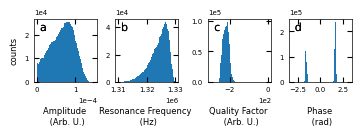

In [20]:
# we will add the appropriate phase shift to the dataset based on the fix seed,
# If your seed is different the results might vary
dataset.NN_phase_shift = np.pi/2 

# you can view the test and training dataset by replacing X_data with X_test or X_train
pred_data, scaled_param, parm = model.predict(X_data)

BE_viz.SHO_hist(parm, filename="Figure_13_NN_Unscaled_Parameters_Histograms")

**Figure 3.7** Histogram of the fit results for the a) amplitude, b) resonance frequency, c) quality factor, and d) phase.


current_SHO_ranges: [(0, 0.00015), (1310000.0, 1330000.0), (-300, 0), (-3.141592653589793, 3.141592653589793)]
current_dataset_state: {'raw_format': 'complex', 'fitter': 'LSQF', 'scaled': False, 'output_shape': 'pixels', 'measurement_state': 'all', 'LSQF_phase_shift': 1.5707963267948966, 'NN_phase_shift': 1.5707963267948966, 'noise': 0, 'loop_interpolated': False}
dataset is scaled
./Figures/Figure_13_NN_scaled_Parameters_Histograms.png
./Figures/Figure_13_NN_scaled_Parameters_Histograms.svg


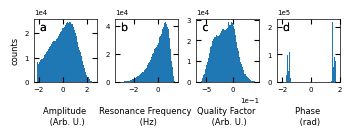

In [21]:
out = dataset.SHO_scaler.transform(parm)

BE_viz.SHO_hist(out, filename="Figure_13_NN_scaled_Parameters_Histograms", scaled=True)

**Figure 3.8** Histogram of the fit results for the a) amplitude, b) resonance frequency, c) quality factor, and d) phase. The histograms show the scaled parameters.


./Figures/Figure_15_NN_Switching_Maps.png
./Figures/Figure_15_NN_Switching_Maps.svg


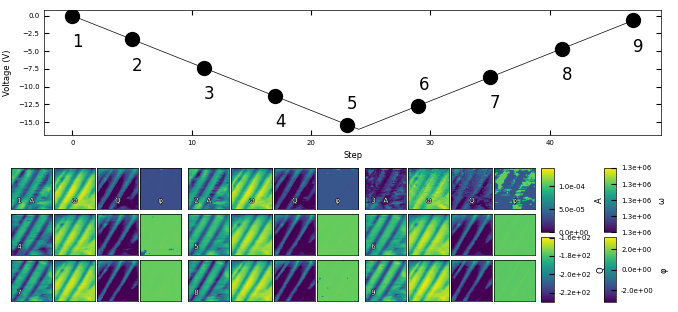

In [22]:
# you can view the test and training dataset by replacing X_data with X_test or X_train
pred_data, scaled_param, parm = model.predict(X_data)

BE_viz.SHO_switching_maps(parm, filename="Figure_15_NN_Switching_Maps")

**Figure 3.9** Snapshots of the amplitude, resonance frequency, quality factor, and phase of the piezoresponse during ferroelectric switching.

## SHO Fitting Movies

In [23]:
# Insatiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]

BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 0), (-np.pi, np.pi)],
             image_scalebar=image_scalebar)

In [24]:
BE_viz.SHO_fit_movie_images(noise = 0, 
                            models = [model],
                            scalebar_= True, 
                            basepath = "Movies/SHO_NN_",  
                            filename="SHO_NN",
                            phase_shift = [np.pi/2],)

Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0000.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0001.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0002.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0003.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0004.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0005.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0006.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0007.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0008.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0009.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0010.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0011.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0012.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0013.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0014.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0015.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0016.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0017.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0018.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0019.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0020.png
Movies/SHO_NN_Noise_0/SHO_NN_noise

Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0034.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0035.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0036.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0037.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0038.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0039.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0040.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0041.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0042.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0043.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0044.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0045.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0046.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0047.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0048.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0049.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0050.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0051.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0052.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0053.png
Movies/SHO_NN_Noise_0/SHO_NN_noise_0_0054.png
Movies/SHO_NN_Noise_0/SHO_NN_noise

100%|██████████| 192/192 [00:25<00:00,  7.51it/s]


## Comparison SHO and Neural Network Fits

3 graphs, best, median, worst

histograms of parameters.


./Figures/Figure_14_LSQF_NN_bmw_comparison.png
./Figures/Figure_14_LSQF_NN_bmw_comparison.svg


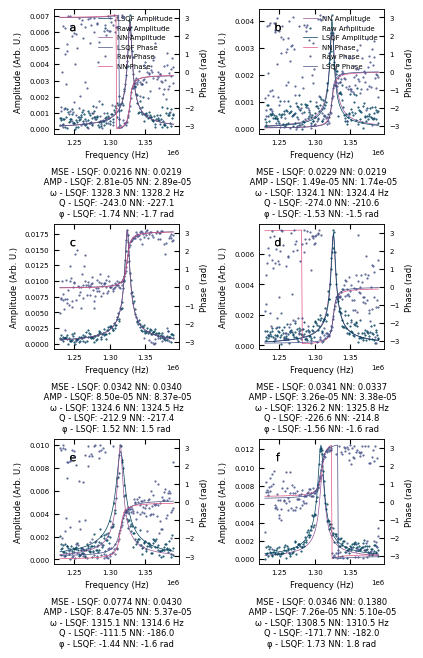

In [25]:
# sets the phase shift of the dataset
dataset.NN_phase_shift = np.pi/2
dataset.LSQF_phase_shift = np.pi/2
dataset.measurement_state = "all"

# sets the true state which to compare the results.
true_state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
    "measurement_state": "all",
}

# sets the state of the output data
out_state = {"scaled": True, "raw_format": "magnitude spectrum"}

# sets the number of examples to get
n = 1

LSQF = BE_viz.get_best_median_worst(
    true_state,
    prediction={"fitter": "LSQF"},
    out_state=out_state,
    SHO_results=True,
    n=n,
)

NN = BE_viz.get_best_median_worst(
    true_state, prediction=model, out_state=out_state, SHO_results=True, n=n
)

data = (LSQF, NN)
names = ["LSQF", "NN"]

BE_viz.SHO_Fit_comparison(
    data,
    names,
    model_comparison=[model, {"fitter": "LSQF"}],
    out_state=out_state,
    filename="Figure_14_LSQF_NN_bmw_comparison",
    verbose=False,
)

**Figure 3.10** Comparison of the a,b) best , c,d) median, and e,f) worst simple harmonic oscillator fits. a,c,e) are based on the fit results from the simple harmonic oscillator model, wherein b,d,f) are based on the neural network model. Generally speaking, all fits are good for both models on the as collected data.

### Statistics of the Results for Training, Validation, and Entire Dataset


./Figures/Figure_16_Violin.png
./Figures/Figure_16_Violin.svg


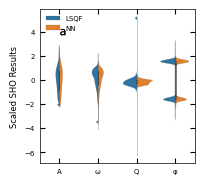

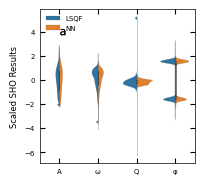

In [34]:
true_state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
    "measurement_state": "all",
}


BE_viz.violin_plot_comparison_SHO(true_state, model, X_data, filename="Figure_16_Violin") 


**Figure 3.11** Violin plot showing the difference in the distribution for the fit results for the LSQF algorithm show in blue, and the NN shown in orange. 

### SHO Comparison Movie

In [35]:
BE_viz.SHO_fit_movie_images(noise = 0, 
                            models=[None, model], 
                            scalebar_= True, 
                            basepath = "Movies/SHO_NN_LSQF_Compare_",  
                            filename="SHO_NN_LSQF_Compare", 
                            labels = ['LSQF', 'NN'],
                            phase_shift = [np.pi/2, np.pi/2])


        Dataset = Raw_Data
        Resample = True
        Raw Format = complex
        Fitter = LSQF
        Scaled = False
        Output Shape = pixels
        Measurement State = on
        Resample Resampled = True
        Resample Bins = 165
        LSQF Phase Shift = 1.5707963267948966
        NN Phase Shift = 1.5707963267948966
        Noise Level = 0
        Loop Interpolated = False
        
None

        Dataset = Raw_Data
        Resample = True
        Raw Format = complex
        Fitter = LSQF
        Scaled = False
        Output Shape = pixels
        Measurement State = off
        Resample Resampled = True
        Resample Bins = 165
        LSQF Phase Shift = 1.5707963267948966
        NN Phase Shift = 1.5707963267948966
        Noise Level = 0
        Loop Interpolated = False
        
None
Movies/SHO_NN_LSQF_Compare_Noise_0/SHO_NN_LSQF_Compare_noise_0_0000.png
Movies/SHO_NN_LSQF_Compare_Noise_0/SHO_NN_LSQF_Compare_noise_0_0001.png
Movies/SHO_NN_LSQF_Compare_Noise_

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [01:28<00:00,  2.18it/s]


### Outliers Visualization

Resonance outliers

./Figures/Figure_14_LSQF_NN_bmw_comparison.png
./Figures/Figure_14_LSQF_NN_bmw_comparison.svg


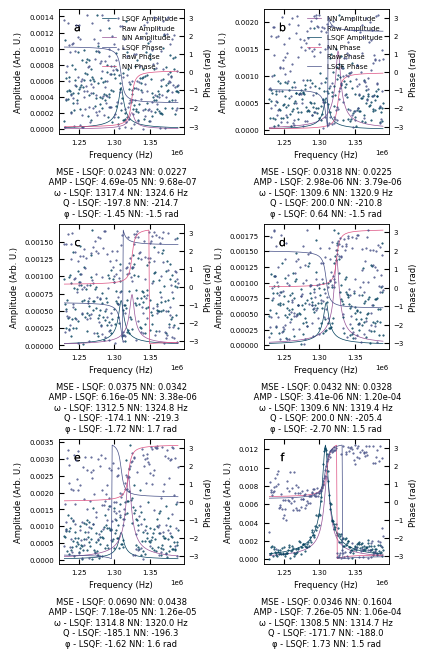

In [41]:

dataset.measurement_state = "all"
dataset.NN_phase_shift = np.pi/2
dataset.LSQF_phase_shift = np.pi/2

true_state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
    "measurement_state": "all",
}

# gets the parameters from the SHO LSQF fit
true = dataset.SHO_fit_results(state = true_state).reshape(-1, 4)

# finds the index less than a certain value
ind = np.argwhere(true[:,1]< -3).flatten()


true_state = {
    "fitter": "LSQF",
    "raw_format": "complex",
    "resampled": True,
    "scaled": True,
    "output_shape": "index",
    "measurement_state": "all"
}

out_state = {"raw_format": "magnitude spectrum", "measurement_state": "all"}

n = 1

LSQF = BE_viz.get_best_median_worst(
    true_state,
    prediction={"fitter": "LSQF"},
    out_state=out_state,
    SHO_results=True,
    n=n,
    index = ind,
    verbose = False
)

NN = BE_viz.get_best_median_worst(
    true_state, prediction=model,
    out_state=out_state, SHO_results=True, n=n, index = ind, verbose = False,
)

data = (LSQF, NN)
names = ["LSQF", "NN"]

BE_viz.SHO_Fit_comparison(
    data,
    names,
    model_comparison=[model, {"fitter": "LSQF"}],
    out_state=out_state,
    filename="Figure_14_LSQF_NN_bmw_comparison",
    verbose = False
)

**Figure 3.12** One thing that was noticed was the LSQF results showed outliers for the Resonance. We find all values from the outlier distribtion from the LSQF, and plot the comparison of the a,b) best , c,d) median, and e,f) worst simple harmonic oscillator fits. a,c,e) are based on the fit results from the simple harmonic oscillator model, wherein b,d,f) are based on the neural network model. The neural network performs better in this distribution. It is worth noting that the best response is obtained when the amplitude, and thus the error, is small. 